# Xe Propellant Storage
Can metal-organic frameworks (MOFs) confer a benefit for storing Xe? For applications as propellant for a spacecraft, the goal is to minimize the total mass carried into space. To contrast the competeing setups, the total mass being lifted is composed of the following:
- for compressed Xe (`cXe`) storage (no MOF, a free-space tank): the xenon needed and the material that composes the tank
- for adsorbed Xe (`aXe`) storage (a tank packed with MOF): the xenon needed, the material that composes the tank *and* the adsorbent material.

The idea is that we can reduce the amount of required tank material by lowering the pressure needed to store a given density of Xe via the implimentation of MOFs. The tradeoff is, however, that the MOF material will also have to be carried in the tank. Therefore, the question is whether the reduced mass of the tank material outweighs the extra mass of this adsorbent material being into space.


Chung's MoF Database with cif files for simulated clean Mofs [link](https://zenodo.org/record/3370144) <- not using this anymore

In [1]:
using PyPlot
using PorousMaterials
using CSV
using DataFrames
using Printf

PyPlot.matplotlib.style.use("Solarize_Light2")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16 ;

The xenon gas is stored in the tank at room temperature `T` before launch. (still cannot find a source for this, but it seems that there simply isn't a temperature controll system specifically for the xenon tanks on the ground of in orbit, so they are simply at ambient temperature; howwever, I did read that as the tank is being filled that they have to controll the fill rate in order to not exceed the tanks range of operable temperatures which is capped at $55^oC$ according to the source listed below.

[1] Tam,  W.;  Jackson,  A.;  Nishida,  E.;  Ka-sai, Y.; Tsujihata, A.; Kajiwara, K. Designand  manufacture  of  the  ETS  VIII  xenontank.36thAIAA/ASME/SAE/ASEEJoint  Propulsion  Conference  and  Exhibit.2000; p 3677.(https://doi.org/10.2514/6.2000-3677)

[2] Welsch,  G.;  Boyer,  R.;  Collings,  E.Materials properties handbook: titanium alloys;ASM international, 1993. 

[3] Niinomi,   M.   Mechanical   properties   of biomedical  titanium  alloys. Materials Science and Engineering: A1998,243, 231–236.

[4] propellant storage considerations [link](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf)

The ambient temperature of the craft is assumed to be ~300K when it is in orbit [4].
Additionally, the tanks opperating temperatures are listed as $278K-328K (5^oC -55^oC)$ [1]

In [2]:
const temperature = 298.0; # K 

The typical amount of super critical Xe to bring into space per tank is 89 kg [1].

In [3]:
xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

mass_desired_xe_propellant = 89.0 # kg Xe
mol_desired_xe_propellant = mass_desired_xe_propellant * 1000 / xe_atomic_mass # mol Xe

677.8731539381383

Properties of anealed Ti-6Al-4V (tank material):

We model the pressure vessel as a thin-walled pressure vessel where the density `ρ` and yield strength `σ` of the tank material are listed below.

Ti-6Al-4V is the titanium alloy that is most commonly used tank shell material [1]. The numbers below are from [ASM](http://asm.matweb.com/search/SpecificMaterial.asp?bassnum=MTP641) webpage are in good agreement with the published values [2],[3]. 

In [4]:
# # Kevlar 49 Source: http://www.mse.mtu.edu/~drjohn/my4150/props.html
# const ρ_tank_material = 1470.0 # kg/m³
# const σ_tank_material = 28000.0 # bar

const ρ_tank_material = 4428.785 # kg/m³ (convdrted from 0.16 lb/in³ listed in [2])
const σ_tank_material = 8250.0 # bar Yield Strength (lower-limit of reported values [3])

8250.0

To justify our range of considered pressures: the range of storage pressures considered goes from an empty tank at 0 bar to well above the maximum expected operating pressure (MEOP) described in the technichal report as 150 bar [1].

## xenon gas properties

Source for experimental data for (real) xenon gas: [NIST](https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoTherm&Digits=5&PLow=0&PHigh=350&PInc=0.01&T=298.00&RefState=DEF&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm). Load in NIST data on xenon at 298 K. source for critical pressure [here](https://webbook.nist.gov/cgi/fluid.cgi?T=298.0&PLow=&PHigh=&PInc=&Applet=on&Digits=5&ID=C7440633&Action=Load&Type=IsoTherm&TUnit=K&PUnit=bar&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF)

In [5]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
# we want higher resolution data at low pressures for doing comparisons with the experimental isotherm data
df_low_p_xe_data = CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

insertcols!(df_low_p_xe_data, 3, density_mol_m3=df_low_p_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_low_p_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

,Temperature (K),Pressure (bar),Density (mol/m³),Density (mol/l),Volume (l/mol)
,Float64,Float64,Float64,Float64,String
1,298.0,0.0,0.0,0.0,infinite
2,298.0,0.58333,23.615,0.023615,42.346
3,298.0,1.1667,47.376,0.047376,21.108
4,298.0,1.75,71.284,0.071284,14.028
5,298.0,2.3333,95.342,0.095342,10.489


For convenience, we define our array of pressures to use in the study as those in the NIST data and get the corresponding densities of the (real) xenon gas.

In [6]:
const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const low_pressures = df_low_p_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar

const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³
const low_ρ_xe = df_low_p_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

get density of ideal gas at our array of `pressures` for comparison.

In [7]:
# Universal Gas Constant:
const R = 8.3144598e-5; # m³-bar/(K-mol)
# ideal gas density
ρ_ideal_gas = pressures / (R * temperature); # mol / m³

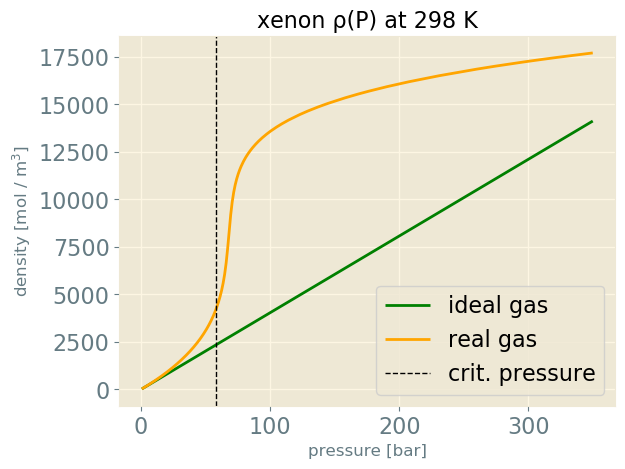

PyObject Text(0.5, 1, 'xenon ρ(P) at 298 K')

In [8]:
figure()
plot(pressures, ρ_ideal_gas, color="green", label="ideal gas")
plot(pressures, ρ_xe, 
    color="orange", label="real gas")
xlabel("pressure [bar]")
axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
ylabel("density [mol / m\$^3\$]")
legend()
title("xenon ρ(P) at 298 K")
# savefig("xenon_gas_density.pdf", format="pdf")

## Compressed xenon (`cXe`) storage

The premise is that we are storing some quantity `mol_desired_xe_propllant` at a specified `temperature`.

For all arrays below, element `i` represents the parameters when we choose to store at `pressures[i]` (bar); for example, `V_cXe_tank[i]` is the volume of the tank required to store the desired quantity `mol_desired_xe_propllant` (mol) of Xe at 298 K and pressure `pressures[i]` bar.

The interior volume of the tank must be equal to the volume of propellant ($V_{tank} = V_{gas} = m_p/\rho_p$ where $\rho_p$ is the density of the gas at a certain pressure). Since we have the density of the propellant at each pressure, we thus know the volume of the tank at each choice of storage pressure.

In [9]:
volume_cxe_tank = mol_desired_xe_propellant ./ ρ_xe; # m³

Assuming the tank is spherical, we can calculate the radius of the tank for each choice of storage pressure.

In [10]:
radius_cxe_tank = (volume_cxe_tank * 3 / (4 * π)) .^ (1 / 3); # m

### Apply stress model
We apply the thin-walled tank stress model to obtain the minimum wall thickness required to contain the pressure of the compressed xenon. The thickness of the wall is found by solving the force balance equation for the spherical, thin-walled tank. By taking the force of the fluid over a cross-sectional area ($ P \pi  r ^ 2$) set equal to the force of the tank walls over the circumference, including the yield strength, safety factor ($\beta$), and thickness of the wall ($2 \pi  r \sigma_y \beta t$). We then isolate $t$ to solve for the thickness.

\begin{equation}
t = \frac{Pr \beta}{2 \sigma_y}
\end{equation}

Then, the we get the following expression for the thickness of the spherical tank:

\begin{equation}
t = \frac{P \beta}{2 \sigma_y} \left( \frac{3m_p}{4 \pi \rho_p} \right)^{1/3}
\end{equation}

The mass of the tank is then: 

\begin{equation}
m_t = 4 \pi t \rho_t = \frac{3 m_p P \beta \rho_t}{2 \sigma_y \rho_p}
\end{equation}

where $\rho_t$ is the density of the tank material. 

In [11]:
const β = 2.5 # this is the saftey factor (unitless)
thickness_cxe_tank = pressures .* radius_cxe_tank * β / (2 * σ_tank_material); # tank wall thickness (m)

The mass of the tank can be found using the surface area of sphere, the thickness of the sphere, and the density of the material.

In [12]:
mass_cxe_tank_material = ρ_tank_material * 4 * π * radius_cxe_tank .^ 2 .* thickness_cxe_tank; # kg
argmin_tank_mass = argmin(mass_cxe_tank_material) # find the index of the minimum value in the tank mass

135

The optimum storage pressure is 77.58 bar with a tank mass of 9.01 kg.
optimum: 
	storage pressure [bar] = 

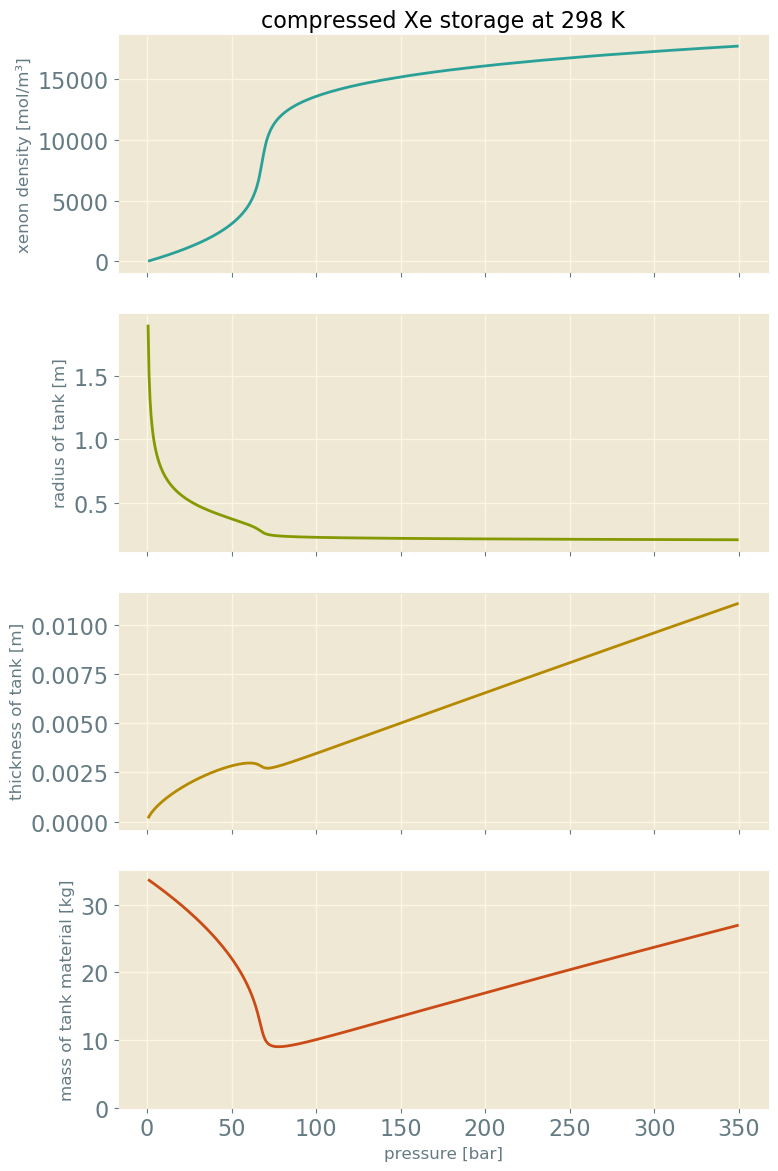

77.583
	mass of tank material [kg] = 9.007995991924963
	tankage fraction [kg] = 0.10121343811151644
	storage density [mol/m³] = 11753.0


(0.0, 34.94330406348294)

In [13]:
@printf("The optimum storage pressure is %.2f bar with a tank mass of %.2f kg.\n", 
    pressures[argmin_tank_mass],mass_cxe_tank_material[argmin_tank_mass])

println("optimum: ")
println("\tstorage pressure [bar] = ", pressures[argmin_tank_mass])
println("\tmass of tank material [kg] = ", mass_cxe_tank_material[argmin_tank_mass])
println("\ttankage fraction [kg] = ", mass_cxe_tank_material[argmin_tank_mass] / mass_desired_xe_propellant)
println("\tstorage density [mol/m³] = ", ρ_xe[argmin_tank_mass])


fig, axs = subplots(4, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)

axs[1].plot(pressures, ρ_xe, color="C1")
axs[1].set_ylabel("xenon density [mol/m³]")
axs[1].set_title("compressed Xe storage at 298 K")

axs[2].plot(pressures, radius_cxe_tank, color="C2")
axs[2].set_ylabel("radius of tank [m]")
# axs[2].ylim(ymin=0.0)

axs[3].plot(pressures, thickness_cxe_tank, color="C3")
axs[3].set_ylabel("thickness of tank [m]")
# axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

axs[4].plot(pressures, mass_cxe_tank_material, color="C4")
axs[4].set_ylabel("mass of tank material [kg]")


xlabel("pressure [bar]")
ylim(ymin=0.0)

### Tankage fraction for compressed xenon

The tankage fraction is ratio between the total mass of the storage tank (later this value will include the additional mass of the adsorbant material) ad the mass of the stored propellant.

\begin{equation}
f_{tankage} = \frac{m_t}{m_p} = \frac{3 P \beta \rho_t}{2 \sigma_y \rho_p}
\end{equation}

We aim to optimize this number.

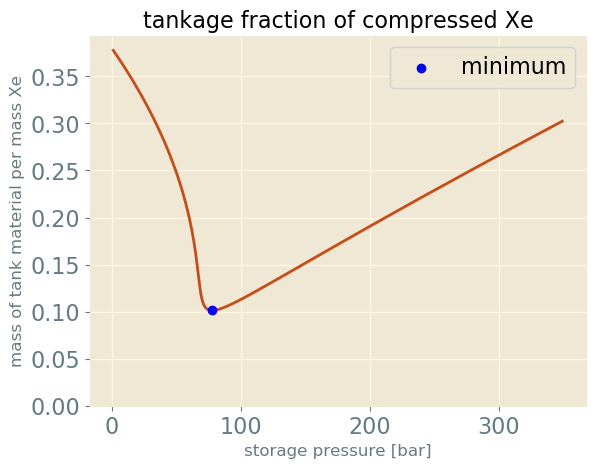

PyObject Text(0.5, 1, 'tankage fraction of compressed Xe')

In [14]:
cxe_tankage_fraction = mass_cxe_tank_material ./ mass_desired_xe_propellant

figure()
plot(pressures, cxe_tankage_fraction, color="C4")
scatter(pressures[argmin_tank_mass], cxe_tankage_fraction[argmin_tank_mass], 
    label="minimum", color="b", zorder=10)

xlabel("storage pressure [bar]")
ylabel("mass of tank material per mass Xe")
legend()
ylim(ymin=0.0)
title("tankage fraction of compressed Xe")
#savefig("Xenon van der Waals Gas in Titanium.pdf", format="pdf")

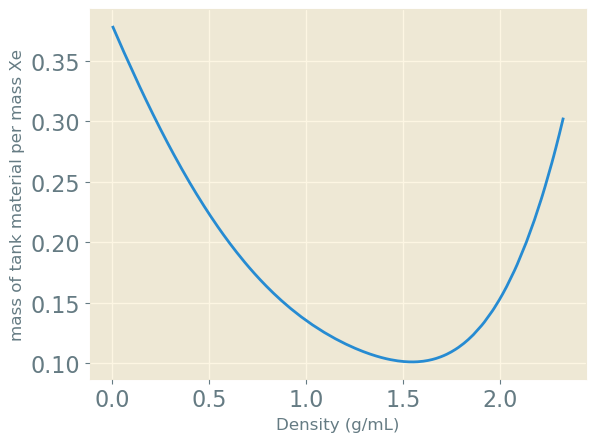

PyObject Text(25.000000000000014, 0.5, 'mass of tank material per mass Xe')

In [15]:
# plot tankage fraction againt gas density (figure 2 in paper)
# mol/m3 * (131 g Xe/ mol) * (1 m3 / 1000000 cm3)
figure()
plot(ρ_xe * xe_atomic_mass / 1000000, cxe_tankage_fraction)
xlabel("Density (g/mL)")
ylabel("mass of tank material per mass Xe")

$\checkmark$ compare tankage fraction to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). optimum tankage fraction in this work is around 0.065. <br>
$\checkmark$ compare optimum storage pressure to previous work [here](https://erps.spacegrant.org/uploads/images/images/iepc_articledownload_1988-2007/1991index/IEPC1991-107.pdf). the  optimum storage density in this work is around 9900 mol/m$^3$= 1.3 g/mL.

# Adsorbed xenon `aXe` storage

Now we are going to consider the situation were the xenon gas is stored in a MOF by the process of adsorption which is then contained inside the tank.

### Load in and prepare MOF Crystal Data and Isotherms

create an array of the crystals we are considering.

In [16]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
    "FMOF-Cu", "MOF-505", "Activated-Carbon"] 
# removed: "ZincTetrazolate" b/c poor Langmuir fit and IRMOF-1, PCN-14 b/c we can't extrapolate confidently

9-element Array{String,1}:
 "SBMOF-1"         
 "CC3"             
 "Ni-MOF-74"       
 "HKUST-1"         
 "SBMOF-2"         
 "Co-formate"      
 "FMOF-Cu"         
 "MOF-505"         
 "Activated-Carbon"

to aid our visualizations, map mofs to markers

In [17]:
mof_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "FMOF-Cu" => "s", "MOF-505" => "v", "Activated-Carbon" => "d")

Dict{String,String} with 9 entries:
  "Ni-MOF-74"        => "<"
  "SBMOF-2"          => "H"
  "FMOF-Cu"          => "s"
  "CC3"              => ">"
  "Activated-Carbon" => "d"
  "SBMOF-1"          => "o"
  "HKUST-1"          => "*"
  "MOF-505"          => "v"
  "Co-formate"       => "^"

#### compute crystal densities of the materials using crystal structure data from [here](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/tree/master/xtal_structures), and [Activated-Carbon](https://www.evoqua.com/en/brands/IPS/productinformationlibrary/WSAQ12DS.pdf) as a reference from [this paper](https://pubs.rsc.org/en/content/articlehtml/2012/cc/c1cc14685h) even though it had been ground and sieved to 180–250 micron particle size.

In [18]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    if crystal_name != "Activated-Carbon"
        framework = Framework(crystal_name * ".cssr")
        strip_numbers_from_atom_labels!(framework)
        ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
    else
        ρ_crystal[crystal_name] = 500.0 # kg/m³
    end
end

ρ_crystal # kg/m³

Dict{String,Float64} with 9 entries:
  "Ni-MOF-74"        => 1194.12
  "SBMOF-2"          => 1191.92
  "FMOF-Cu"          => 1619.15
  "CC3"              => 958.585
  "Activated-Carbon" => 500.0
  "SBMOF-1"          => 1570.4
  "HKUST-1"          => 879.096
  "MOF-505"          => 926.618
  "Co-formate"       => 1821.5

#### read in experimental adsorption isotherm data [source](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/tree/master/data )

In [19]:
path_to_isotherms = joinpath("data", "exptl_xe_isotherms")

"data/exptl_xe_isotherms"

In [20]:
xe_isotherms = Dict{String, DataFrame}()

# consider not using "ZincTetrazolate" since it can't be fit using langmuir due to the shape of the data

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_isotherms, crystal_name, "Xe.csv")
    # some mofs have a hysteresis curve that needs to be removed from the data manually
    if crystal_name == "FMOF-Cu" 
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 15:24)
    elseif crystal_name == "SBMOF-2"
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 30:39)
    else
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename) 
    end
end

xe_isotherms

Dict{String,DataFrame} with 9 entries:
  "Ni-MOF-74"        => 14×2 DataFrame…
  "SBMOF-2"          => 29×2 DataFrame…
  "FMOF-Cu"          => 14×2 DataFrame…
  "CC3"              => 27×2 DataFrame…
  "Activated-Carbon" => 13×2 DataFrame…
  "SBMOF-1"          => 16×3 DataFrame…
  "HKUST-1"          => 16×2 DataFrame…
  "MOF-505"          => 30×2 DataFrame…
  "Co-formate"       => 25×2 DataFrame…

### Convert isotherms to same units

Here we convert to common units: P (bar) and Adsorption (mol/m³)

Although it is quick (and handy) to use a dictionary for the unit conversion, 
it does mean that you will have to manually enter the names and conversion factors needed.<br>
- consider checking out the Unitful.jl package [here](http://painterqubits.github.io/Unitful.jl/stable/)
- unit conversions are consistent similar work [here](https://github.com/CorySimon/XeKrMOFAdsorptionSurvey/blob/master/Xe-Kr%20adsorption%20isotherm%20survey.ipynb)

In [21]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)

1000.0

**iterate over the dataframes and apply the unit conversion:**

In [22]:
for mof in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[mof])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[mof][!, common_pressure_units] = xe_isotherms[mof][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[mof][!,common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[mof][!,common_loading_units] = xe_isotherms[mof][!, col_name] * loading_conversion[col_name] * ρ_crystal[mof] 
            end 
        else  
            print(mof, " has units with unknow conversion: ",col_name,"\n") 
        end
    end
end

SBMOF-1 has units with unknow conversion: Weight(mg)


In [23]:
first(xe_isotherms["Ni-MOF-74"], 5)

,PercentMass,P(mbar),Loading (mol/m³),Pressure (bar)
,Float64,Float64,Float64,Float64
1,1.0e-5,0.004,0.000909508,4.0e-6
2,0.066972,0.055,6.09116,5.5e-5
3,5.46842,50.381,497.357,0.050381
4,10.8992,98.112,991.295,0.098112
5,16.3871,148.758,1490.42,0.148758


### Fit Langmuir adsorption model to the MOF xenon adsorption data

In [24]:
"""
plot MOF data along with Langmuir fit and compare to bulk gas density

# Arguments
* `df_xe::DataFrame` the dataframe corresponding to the set of bulk xenon data you 
    want to use in the plot containing the range of pressures (bar) and 
    associated densities (mol/m³)
* `mof::String` a string that is the name of the material you are interested in plotting
* `max_pressure::Float64` the upper bound of the pressures you want are interested in

"""
function plot_mof_data_and_langmuir_fit(mof::String, max_pressure::Float64)
    # fit Langmuir adsorption model
    params_langmuir = fit_adsorption_isotherm(copy(xe_isotherms[mof]), common_pressure_units, 
        common_loading_units, :langmuir)
    
    # plot fit
    figure()    
    xlabel("pressure [bar]")
    ylabel("xenon uptake [mol/m³]")
    title(mof)
    # expt'l data
    scatter(xe_isotherms[mof][:, common_pressure_units], 
        xe_isotherms[mof][:, common_loading_units])
    
    # Langmuir fit
    p_plot = range(0.0, stop=max_pressure, length=500)    
    ρ_langmuir = (params_langmuir["M"] .*  params_langmuir["K"] .* p_plot) ./ (1 .+ params_langmuir["K"] * p_plot)
    plot(p_plot, ρ_langmuir)
    
    # bulk gas density
    if max_pressure < 1.5
        plot(df_low_p_xe_data[:, Symbol("Pressure (bar)")], df_low_p_xe_data[:, Symbol("Density (mol/m³)")], 
            label="compressed Xe density", linestyle="--")
    else
        gouptoid = findfirst(df_xe_data[:, Symbol("Pressure (bar)")] .> max_pressure)
        plot(df_xe_data[1:gouptoid, Symbol("Pressure (bar)")], df_xe_data[1:gouptoid, Symbol("Density (mol/m³)")], 
            label="compressed Xe density", linestyle="--")
    end

    legend()
end

plot_mof_data_and_langmuir_fit

### Low Pressure Fits

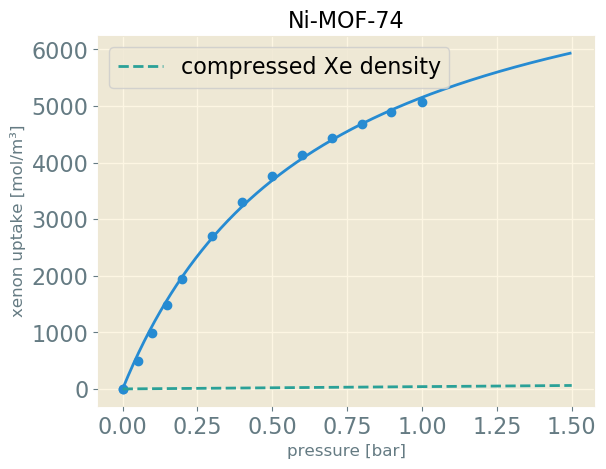

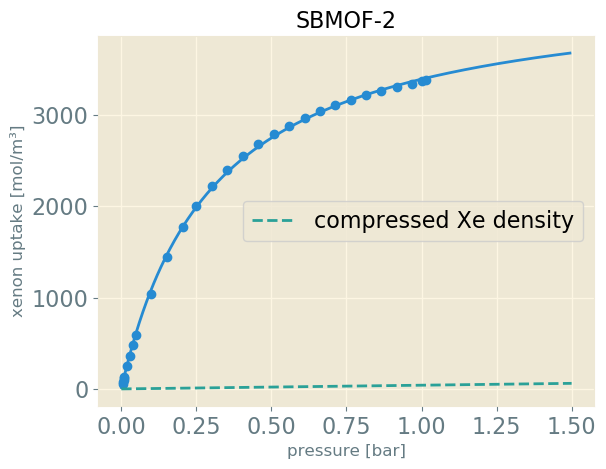

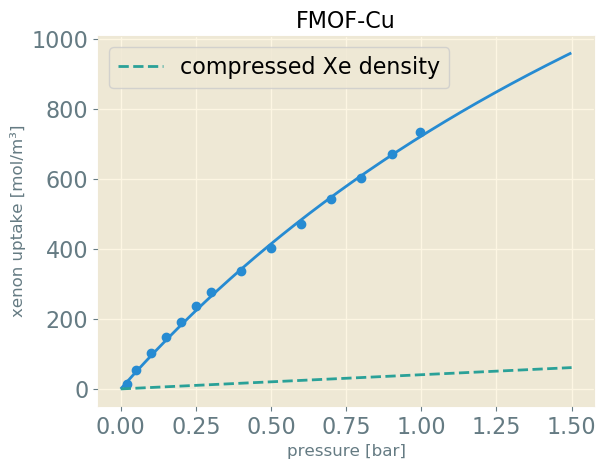

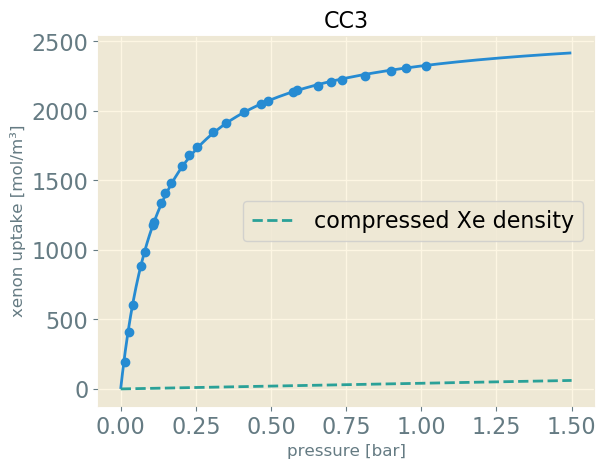

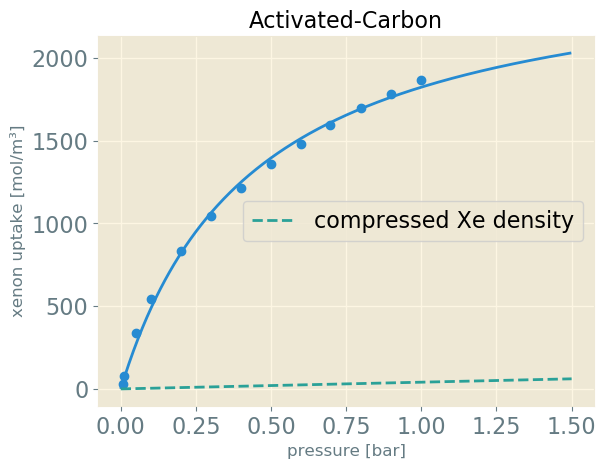

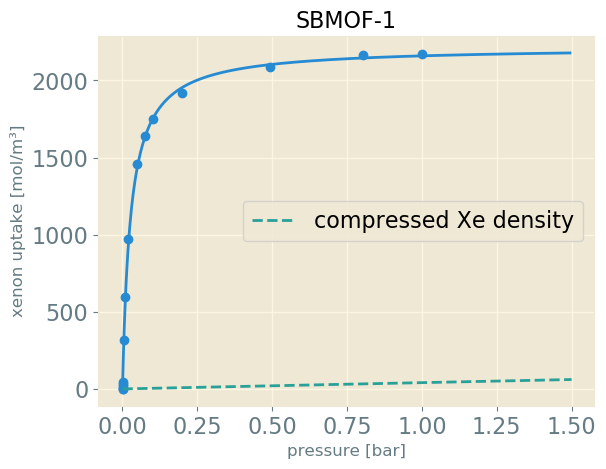

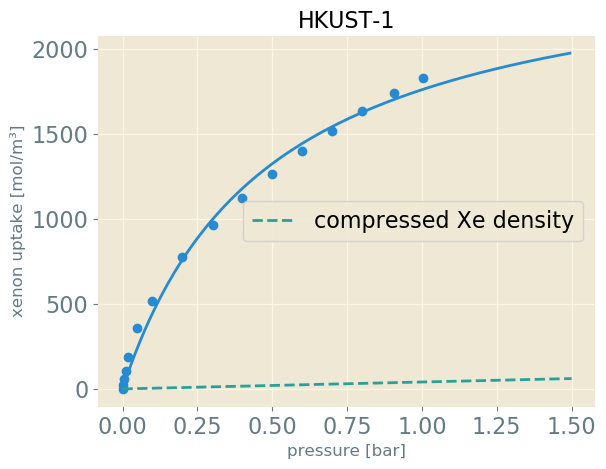

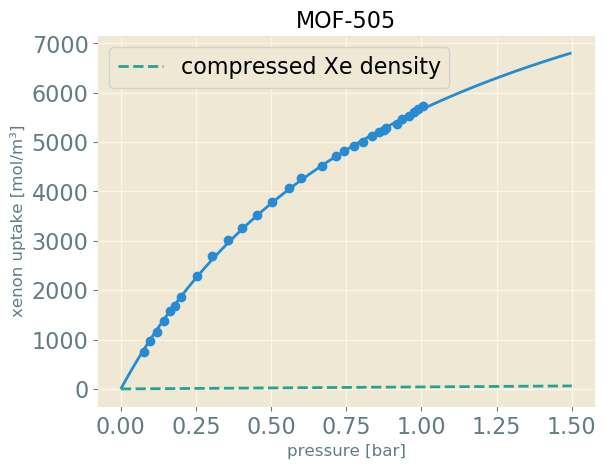

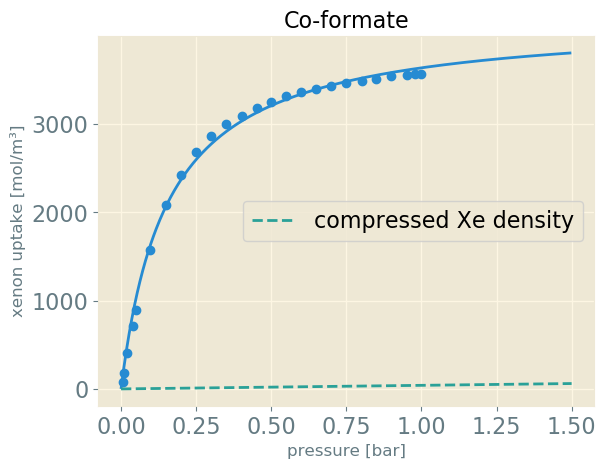

In [25]:
for mof in keys(xe_isotherms)
    plot_mof_data_and_langmuir_fit(mof, 1.499)
end

### High Pressure Fits

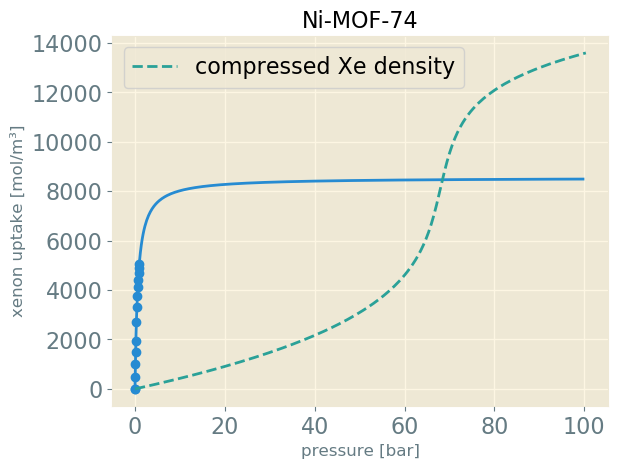

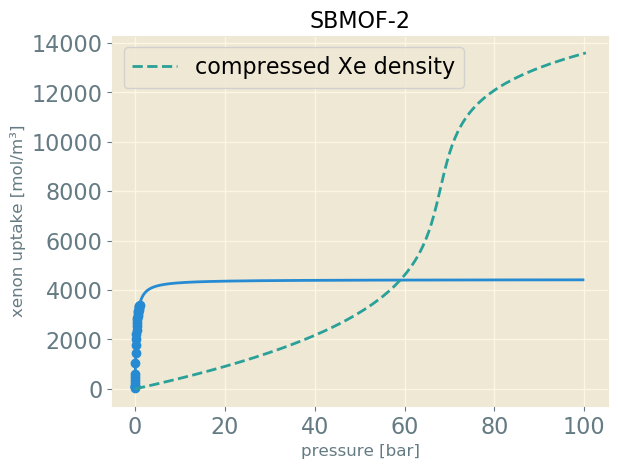

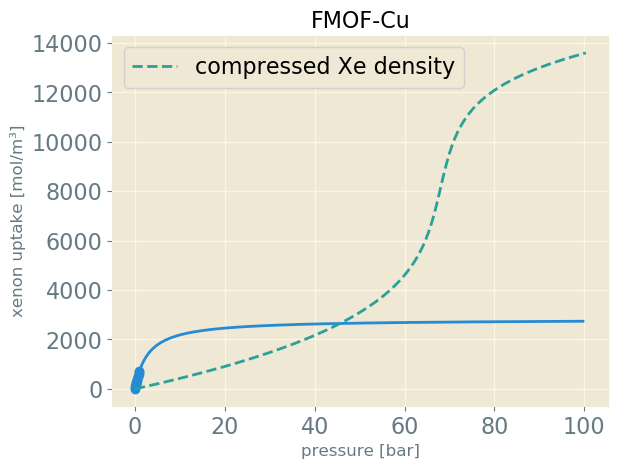

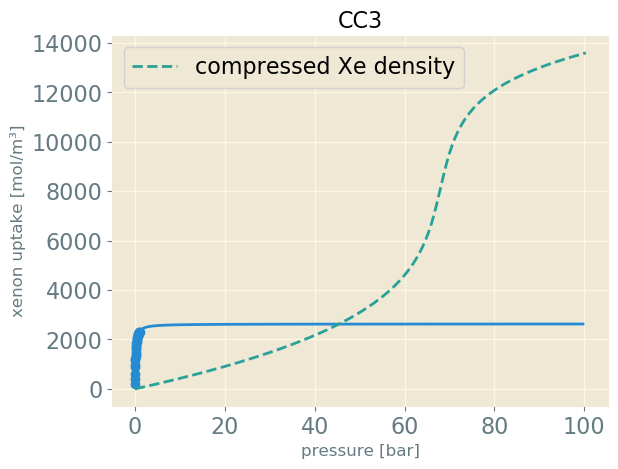

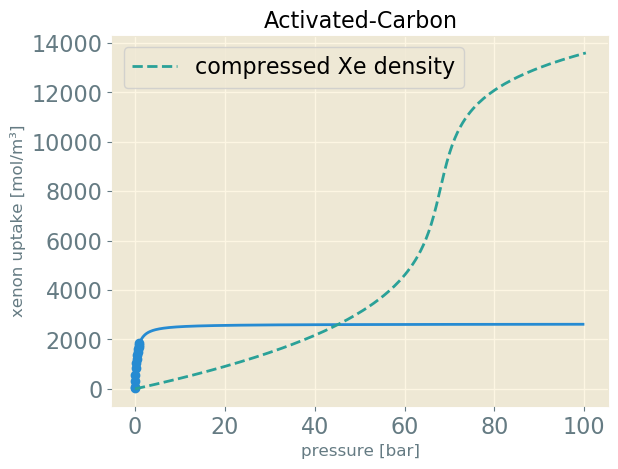

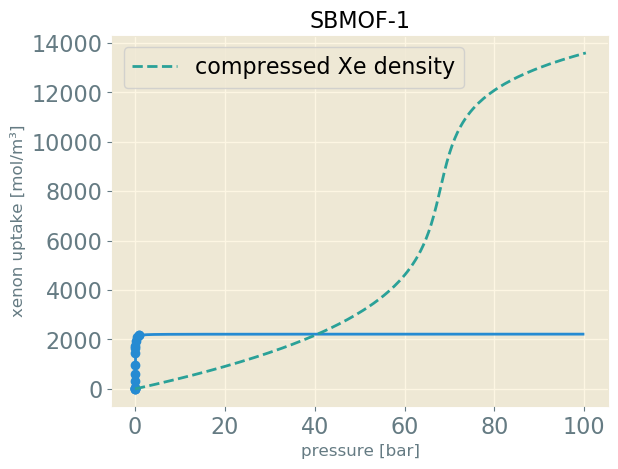

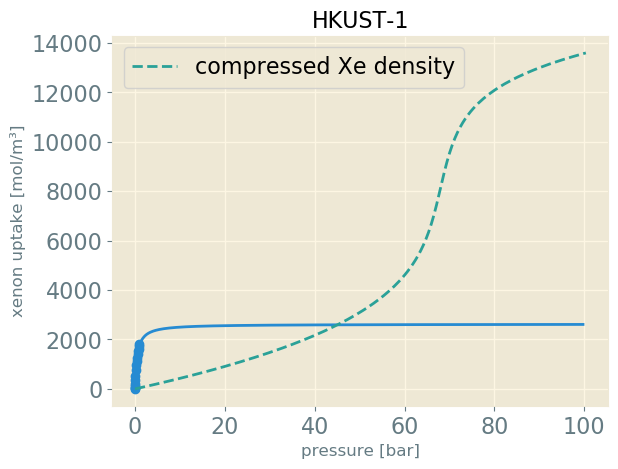

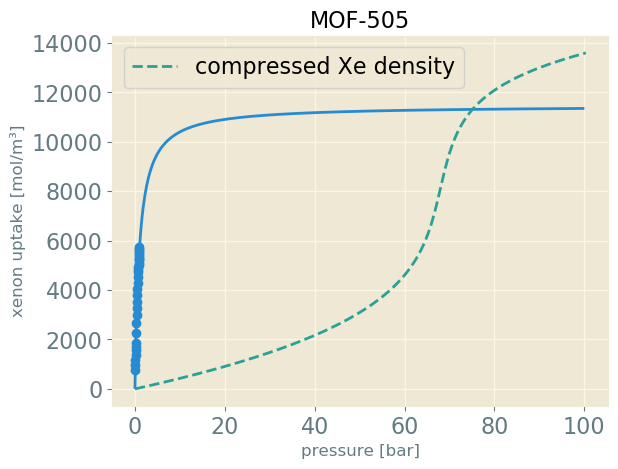

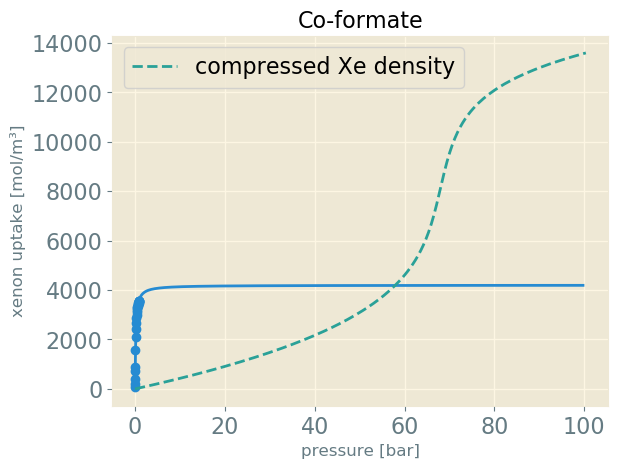

In [26]:
for mof in keys(xe_isotherms)
    plot_mof_data_and_langmuir_fit(mof, 100.0)
end

### We will now analyze the properties of the tank carrying MOF

Using the function `fit_adsorption_isotherm` from Porous Materials, we calculated `M`, the density of gas in the MOF at saturation, and the Langmuir constant `K`. The Langmuir adsorption model for the loading `L` is:
\begin{equation}
L = M KP/(1+KP)
\end{equation} 

Using thin-walled theory, the thickness of the wall of the container storing the mof is equal to the pressure multiplied by the radius of the container divided by two times the tensile strength of the container material. 
\begin{equation}
t_{tank with mof} = P \beta r_{tank with mof} / 2\sigma_y
\end{equation} 

In [27]:
function analyze_adsorbed_xe_tank(df_mof::DataFrame, ρ_mof::Float64)
    # The Langmuir model was then fitted to the experimental data and the root mean square was calculated,
    # showing how good of a fit the model is to the experimental data.
    params_langmuir = fit_adsorption_isotherm(copy(df_mof), common_pressure_units, common_loading_units, :langmuir)
    ρ_langmuir = (params_langmuir["M"] .*  params_langmuir["K"] .* pressures) ./ (1 .+ params_langmuir["K"] * pressures) # mol/m³
    
    # The volume of the tank storing the MOF is equal to the volume of the MOF
    # required to store the desired amount of propellant.
    vol_axe_tank = mol_desired_xe_propellant ./ ρ_langmuir # m³
    
    # Find the corresponding radius of the vessel, assumed spherical.
    radius_axe_tank = (vol_axe_tank .* (3 / (4 * π))) .^ (1 / 3) # m
    
    # Mass of MOF needed to carry desired amount of gas.
    mass_mof_needed = vol_axe_tank * ρ_mof # kg
    
    # Thin-walled theory 
    t_axe_tank = pressures .* radius_axe_tank * β / (2 * σ_tank_material) # m
    
    # The total mass of the tank and MOF for the desired amount of propellant is equal to the mass of the MOF 
    # required to store the desired amount of propellant, plus the mass of the thin-walled tank storing the MOF.
    mass_axe_tank_material = 4 * π * radius_axe_tank .^ 2 .* t_axe_tank * ρ_tank_material # kg
    mass_axe_tank_total = mass_mof_needed .+ mass_axe_tank_material # kg
    
    adsorption_tankage_fraction = mass_axe_tank_total / mass_desired_xe_propellant
    
    return Dict("Mass of tank material (kg)" => mass_axe_tank_material,
                "Mass of MOF needed (kg)" => mass_mof_needed,
                "Total mass of Xe tank (kg)" => mass_axe_tank_total,
                "Density of gas in MOF (mol/m³)" => ρ_langmuir,
                "Adsorption tankage fraction" => adsorption_tankage_fraction,
                "Inner radius (m)" => radius_axe_tank,
                "Thickness of tank walls (m)" => t_axe_tank,
                "Inner volume of tank (m³)" => vol_axe_tank,
                "Langmuir K" => params_langmuir["K"],
                "Langmuir M" => params_langmuir["M"] )
end

analyze_adsorbed_xe_tank (generic function with 1 method)

In [28]:
axe_results = Dict{String, Dict}()

for material in crystal_names
    axe_results[material] = analyze_adsorbed_xe_tank(xe_isotherms[material], ρ_crystal[material]) 
end
axe_results["SBMOF-1"]

Dict{String,Any} with 10 entries:
  "Total mass of Xe tank (kg)"     => [502.649, 491.954, 488.629, 487.146, 486.…
  "Thickness of tank walls (m)"    => [3.74959e-5, 7.44402e-5, 0.000111377, 0.0…
  "Density of gas in MOF (mol/m³)" => [2119.43, 2167.12, 2183.5, 2191.78, 2196.…
  "Mass of MOF needed (kg)"        => [502.274, 491.22, 487.536, 485.693, 484.5…
  "Inner radius (m)"               => [0.424242, 0.421107, 0.420051, 0.419522, …
  "Mass of tank material (kg)"     => [0.375583, 0.73466, 1.09369, 1.45273, 1.8…
  "Adsorption tankage fraction"    => [5.64775, 5.52758, 5.49022, 5.47355, 5.46…
  "Inner volume of tank (m³)"      => [0.319838, 0.312799, 0.310453, 0.30928, 0…
  "Langmuir K"                     => 37.2343
  "Langmuir M"                     => 2217.01

In [29]:
function make_plots(mof_name::String, axe_results::Dict)
    argmin_tankage_fraction = argmin(axe_results["Adsorption tankage fraction"])
    @printf("The optimum storage pressure is %.2f bar with a tank mass of %.2f kg.\n", 
        pressures[argmin_tankage_fraction], axe_results["Mass of tank material (kg)"][argmin_tankage_fraction])

    println("optimum: ")
    println("\tstorage pressure [bar] = ", pressures[argmin_tankage_fraction])
    println("\tmass of tank material [kg] = ", axe_results["Mass of tank material (kg)"][argmin_tankage_fraction])
    println("\ttankage fraction [kg] = ", axe_results["Adsorption tankage fraction"][argmin_tankage_fraction])
    println("\tstorage density [mol/m³] = ", axe_results["Density of gas in MOF (mol/m³)"][argmin_tankage_fraction])

    fig, axs = subplots(4, 1, figsize=(8, 12), 
                    sharex=true, sharey=false, tight_layout=true)
    # plot adsorption isotherm of MOF (Langmuir and raw data)
    axs[1].plot(pressures, axe_results["Density of gas in MOF (mol/m³)"], color="C1", label="Langmuir fit")
    axs[1].scatter(xe_isotherms[mof_name][!, common_pressure_units], xe_isotherms[mof_name][!, common_loading_units],
        label="data")
    axs[1].legend()
    axs[1].set_ylabel("xenon density [mol/m³]")
    axs[1].set_title("Adsobed Xe storage at 298 K")

    # tank radius
    axs[2].plot(pressures, axe_results["Inner radius (m)"], color="C2")
    axs[2].set_ylabel("radius of tank [m]")

    # tank thickness
    axs[3].plot(pressures, axe_results["Thickness of tank walls (m)"], color="C3")
    axs[3].set_ylabel("thickness of tank [m]")
    # axs[3].axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)

    # mass of tank
    axs[4].plot(pressures, axe_results["Mass of tank material (kg)"], color="C7", linestyle="--", label="tank material")
    axs[4].plot(pressures, axe_results["Mass of MOF needed (kg)"], color="C5", linestyle="--", label="MOF material")
    axs[4].plot(pressures, axe_results["Total mass of Xe tank (kg)"], color="C6", label="total")
    axs[4].set_ylabel("mass [kg]")
    axs[4].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="lower left",
           ncol=2, mode="expand", borderaxespad=0)

    xlabel("pressure [bar]")
    ylim(ymin=0.0)
    
    # plot tankage fraction
    figure()
    scatter(pressures[argmin_tankage_fraction], axe_results["Adsorption tankage fraction"][argmin_tankage_fraction],
        label="minimum", color="b", zorder=999)
    plot(pressures, axe_results["Adsorption tankage fraction"], color="C4")
    xlabel("storage pressure [bar]")
    ylabel("total mass of tank / mass Xe")
    legend()
    title("tankage fraction of adsorbed Xe")
    # ylim(ymin=0.0)
    print("Toltal tank mass at optimum pressure = ", axe_results["Adsorption tankage fraction"][argmin_tankage_fraction])

end

make_plots (generic function with 1 method)

The optimum storage pressure is 21.58 bar with a tank mass of 2.69 kg.
optimum: 
	storage pressure [bar] = 21.583
	mass of tank material [kg] = 2.6911694072031267
	tankage fraction [kg] = 0.6751167287536943
	storage density [mol/m³] = 10944.12702181325


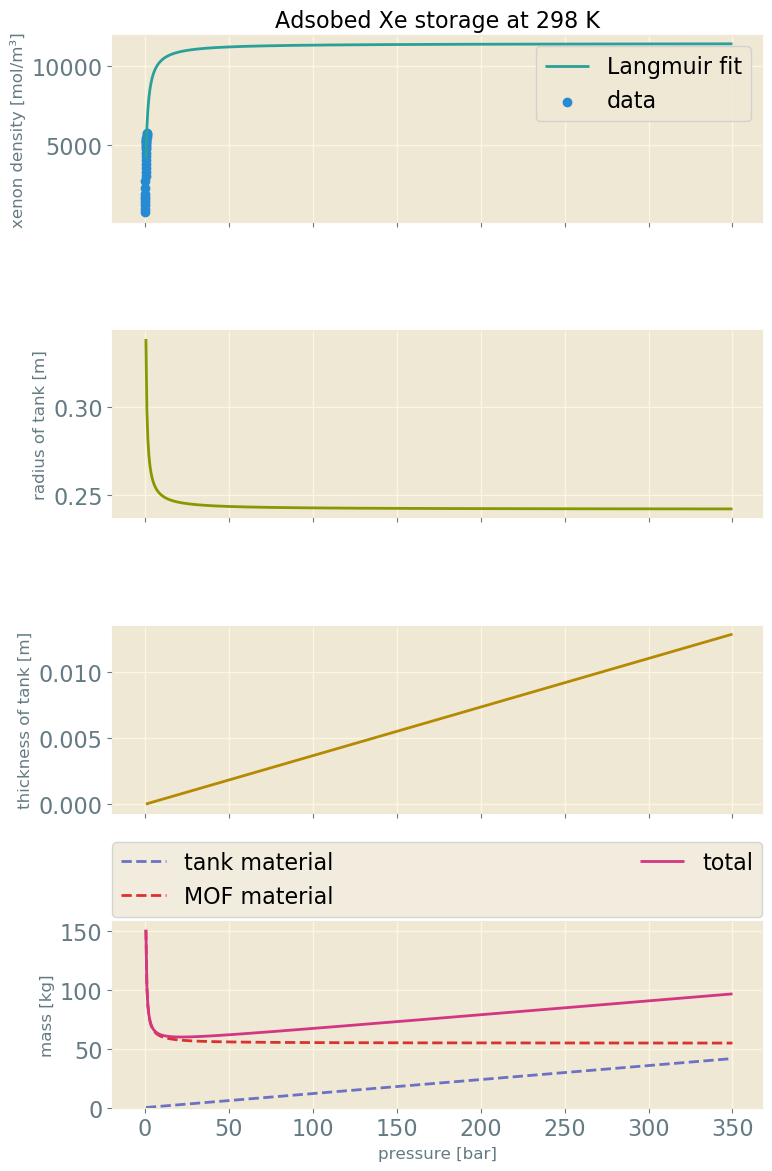

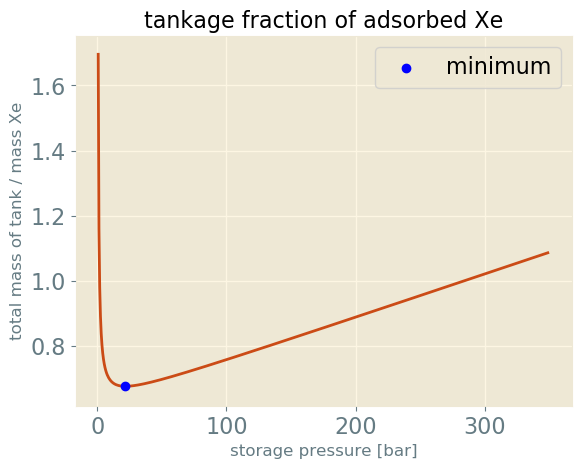

Toltal tank mass at optimum pressure = 0.6751167287536943

In [30]:
make_plots("MOF-505", axe_results["MOF-505"])

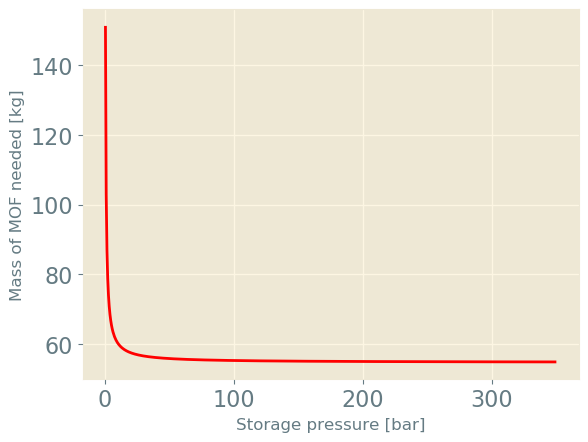

PyObject Text(25.000000000000014, 0.5, 'Mass of MOF needed [kg]')

In [31]:
plot(pressures, axe_results["MOF-505"]["Mass of MOF needed (kg)"], color="r")
xlabel("Storage pressure [bar]")
ylabel("Mass of MOF needed [kg]")

### visualizing the scatter of MOFs in MOF space
MOF space defined by Langmuir model parameters

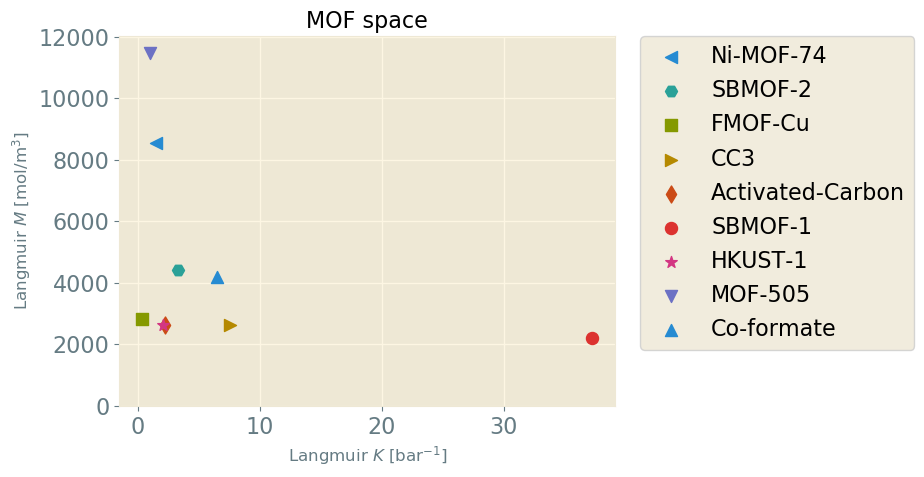

PyObject <matplotlib.legend.Legend object at 0x7f4c1f50af98>

In [32]:
figure()
title("MOF space")
for mof_name in keys(axe_results)
    scatter(axe_results[mof_name]["Langmuir K"], axe_results[mof_name]["Langmuir M"], 
        label=mof_name, marker=mof_to_marker[mof_name], s=75, clip_on=false)
end
xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
ylim(ymin=0.0)
# xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

# need to set colormap to indicate which have better tankage fractions

### visualizing the reduction in storage volume given by the MOFs

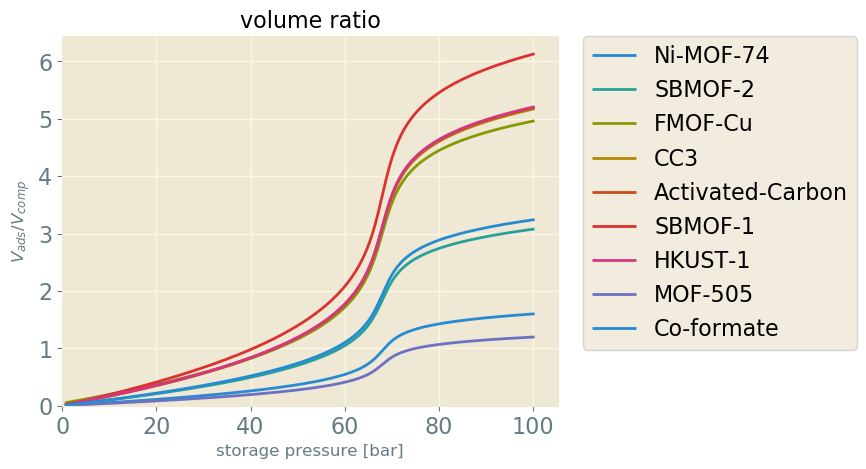

PyObject Text(0.5, 1, 'volume ratio')

In [33]:
id_plot_pmax = findfirst(pressures .> 100.0)
figure()
for mof_name in keys(axe_results)
    plot(pressures[1:id_plot_pmax], 
        axe_results[mof_name]["Inner volume of tank (m³)"][1:id_plot_pmax] ./ volume_cxe_tank[1:id_plot_pmax], 
        label=mof_name)
end
xlabel("storage pressure [bar]")
ylabel(L"$V_{ads} / V_{comp}$")
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
ylim(ymin=0.0)
xlim(xmin=0.0)
title("volume ratio")       

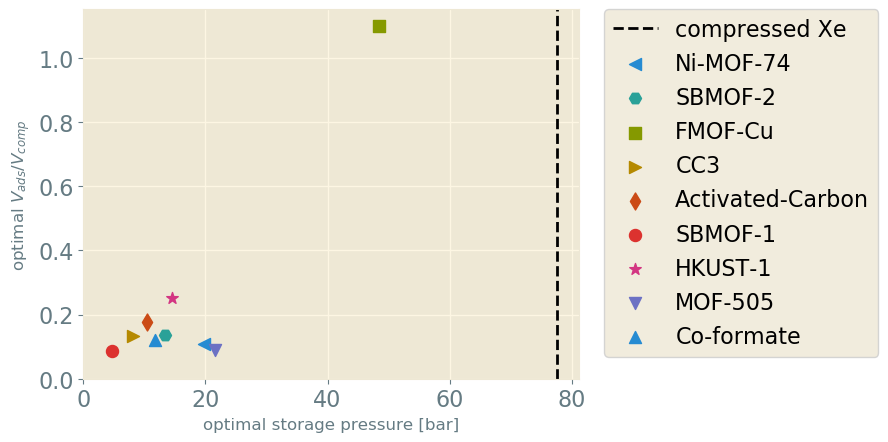

PyObject <matplotlib.legend.Legend object at 0x7f4c1bbba710>

In [34]:
figure()
xlabel("optimal storage pressure [bar]")
ylabel(L"optimal $V_{ads} / V_{comp}$")
for mof_name in keys(axe_results)
    # find where the tank fraction is minimal
    id_opt = argmin(axe_results[mof_name]["Adsorption tankage fraction"])
    # find ratio of volumes at this optimal storage pressure
    V_aXe_ovr_V_cXe = axe_results[mof_name]["Inner volume of tank (m³)"][id_opt] ./ volume_cxe_tank[id_opt]
    scatter(pressures[id_opt], V_aXe_ovr_V_cXe, 
        label=mof_name, marker=mof_to_marker[mof_name], s=75, clip_on=false)
end
axvline(x=pressures[argmin_tank_mass], linestyle="--",
    label="compressed Xe", color="k")
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

## optimal storage pressure vs. tankage fraction

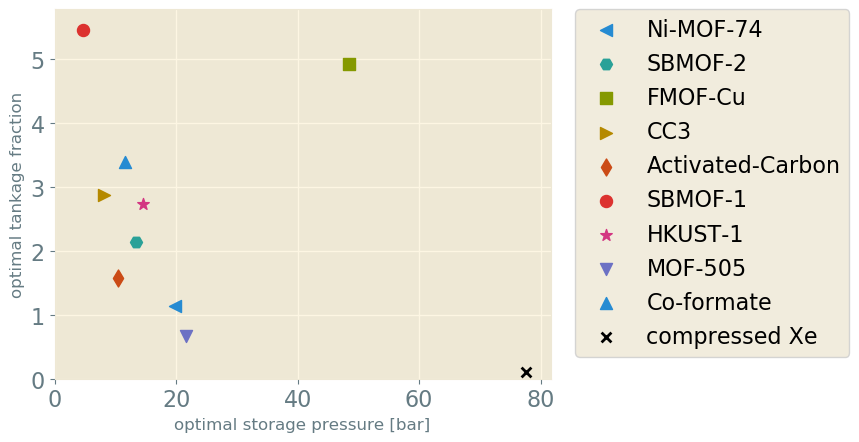

PyObject <matplotlib.legend.Legend object at 0x7f4c1bb641d0>

In [35]:
figure()
xlabel("optimal storage pressure [bar]")
ylabel("optimal tankage fraction")
for mof_name in keys(axe_results)
    # find where the tankage fraction is minimal
    id_opt = argmin(axe_results[mof_name]["Adsorption tankage fraction"])
    scatter(pressures[id_opt], axe_results[mof_name]["Adsorption tankage fraction"][id_opt], 
        label=mof_name, marker=mof_to_marker[mof_name], s=75, clip_on=false)
end
scatter(pressures[argmin_tank_mass], cxe_tankage_fraction[argmin_tank_mass], 
    label="compressed Xe", color="k", zorder=10, s=50, marker="x")
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

## crystal density of MOFs affects tankage fraction

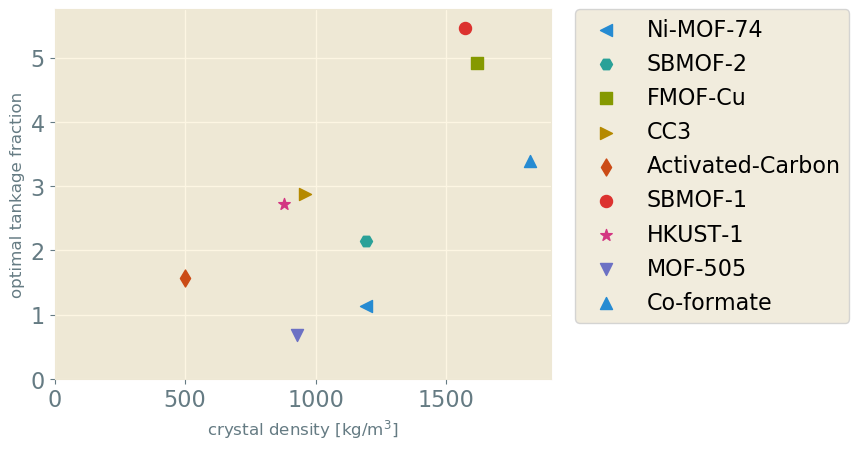

PyObject <matplotlib.legend.Legend object at 0x7f4c1eed56a0>

In [36]:
figure()
xlabel(L"crystal density [kg/m$^3$]")
ylabel("optimal tankage fraction")
for mof_name in keys(axe_results)
    scatter(ρ_crystal[mof_name], minimum(axe_results[mof_name]["Adsorption tankage fraction"]), 
        label=mof_name, marker=mof_to_marker[mof_name], s=75, clip_on=false)
end
ylim(ymin=0.0)
xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

## mass of tank needed, partitioned by MOF vs tank material

In [37]:
ids = 1:length(axe_results)

df_opt_mass = DataFrame(mof=String[], opt_tank_material=Float64[], 
    opt_mof_material=Float64[], opt_tankage_fraction=Float64[])

# for each MOF, find the mof, tank material needed at optimum storage pressure.
for mof_name in keys(axe_results)
    # find id_opt storage pressure
    id_opt = argmin(axe_results[mof_name]["Adsorption tankage fraction"])
    opt_tank_material = axe_results[mof_name]["Mass of tank material (kg)"][id_opt]
    opt_mof_material = axe_results[mof_name]["Mass of MOF needed (kg)"][id_opt]
    opt_tankage_fraction = axe_results[mof_name]["Adsorption tankage fraction"][id_opt]
    push!(df_opt_mass, [mof_name, opt_tank_material, opt_mof_material, opt_tankage_fraction])
end
sort!(df_opt_mass, :opt_tankage_fraction)
df_opt_mass

,mof,opt_tank_material,opt_mof_material,opt_tankage_fraction
,String,Float64,Float64,Float64
1,MOF-505,2.69117,57.3942,0.675117
2,Ni-MOF-74,3.27203,97.8621,1.13634
3,Activated-Carbon,5.68262,134.421,1.5742
4,SBMOF-2,4.23023,186.678,2.14504
5,HKUST-1,7.84451,234.906,2.72753
6,CC3,4.3056,251.047,2.86914
7,Co-formate,3.84314,298.055,3.39211
8,FMOF-Cu,24.8594,412.971,4.91944
9,SBMOF-1,2.88899,482.93,5.45864


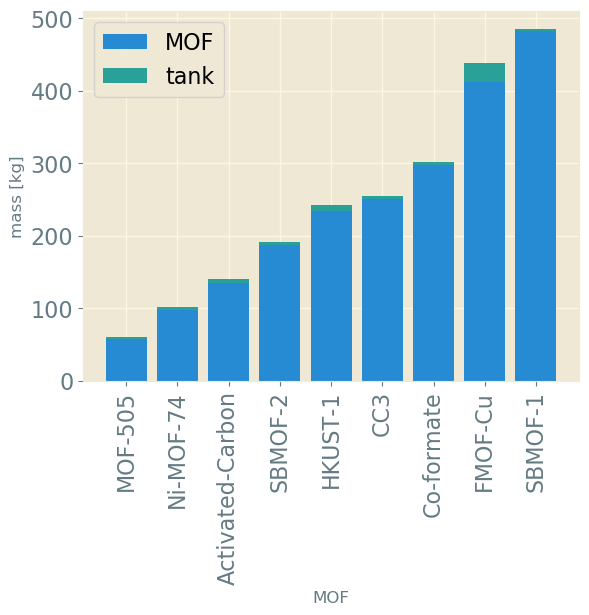

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x7f4c1bb02da0>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bb22a90>, PyObject <matplotlib.axis.XTick object at 0x7f4c1eae3160>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbc5dd8>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbb62e8>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbb6828>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbb6da0>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbaa358>, PyObject <matplotlib.axis.XTick object at 0x7f4c1bbaa8d0>], PyCall.PyObject[PyObject Text(1, 0, 'MOF-505'), PyObject Text(2, 0, 'Ni-MOF-74'), PyObject Text(3, 0, 'Activated-Carbon'), PyObject Text(4, 0, 'SBMOF-2'), PyObject Text(5, 0, 'HKUST-1'), PyObject Text(6, 0, 'CC3'), PyObject Text(7, 0, 'Co-formate'), PyObject Text(8, 0, 'FMOF-Cu'), PyObject Text(9, 0, 'SBMOF-1')])

In [38]:
figure()
xlabel("MOF")
ylabel("mass [kg]")
bar(ids, df_opt_mass[:, :opt_mof_material], label="MOF")
bar(ids, df_opt_mass[:, :opt_tank_material], bottom=df_opt_mass[:, :opt_mof_material], label="tank")
legend()
xticks(ids, df_opt_mass[:, :mof], rotation="vertical")

### TODO: 
#### incorporate COF simulation data into model analysis
* run isotherm simulation for COF-102 and COF-103 $\checkmark$
* load in `.jld2` files
* run COF data through analysis and plot

In [39]:
# file = joinpath("data/sim_xe_isotherms/cof_103_sim/gcmc_103_Xe_T298.000000_P0.032925_UFF_5000burn_10000sample.jld2")
# cof_ads_data = load(file)["results"]